In [1]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
indices_panel = pd.DataFrame.from_csv('../data/indice/indices_panel.csv')
indices_panel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2008-01-04,-1.529998,-1.570008,-3.540039,-40.879883,2.43945,5.489746,-27.990235,-2.300293,515.349609,-464.320313,143.339996
2008-01-07,0.270004,-1.529998,-29.940064,-56.930176,-245.40918,-111.689941,-102.709961,-27.500000,216.951171,-48.830078,141.809998
2008-01-08,-2.990006,0.270004,1.640015,-7.179931,19.75000,44.509766,33.680176,-33.899902,-354.060547,99.370117,142.080002
2008-01-09,0.589997,-2.990006,-25.459961,-63.119873,-230.69043,-17.109864,-5.270020,-12.900390,768.359375,234.450195,139.089996
2008-01-10,1.100006,0.589997,16.530029,8.270019,142.90039,9.140137,-40.120117,-100.200196,-195.560547,-158.209961,139.679993


In [4]:
train = indices_panel.iloc[-2000:-1000, :]
test = indices_panel.iloc[-1000:, :]

In [5]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=train).fit()

In [6]:
train['PredictedY'] = lm.predict(train)
test['PredictedY'] = lm.predict(test)

# Profit of Signal-based strategy

In [7]:
# Train
train['Order'] = [1 if sig > 0 else -1 for sig in train['PredictedY']]
train['Profit'] = train['spy'] * train['Order']

train['Wealth'] = train['Profit'].cumsum()
print('Total profit made in Train: ', train['Profit'].sum())

Total profit made in Train:  214.340095


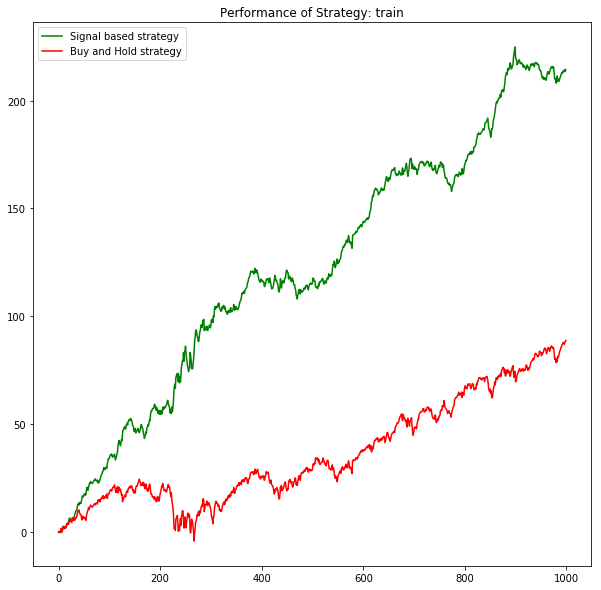

In [8]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy: train')
plt.plot(train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(train['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

In [9]:
# Test
test['Order'] = [1 if sig > 0 else -1 for sig in test['PredictedY']]
test['Profit'] = test['spy'] * test['Order']

test['Wealth'] = test['Profit'].cumsum()
print('Total profit made in Test: ', test['Profit'].sum())

Total profit made in Test:  241.030088


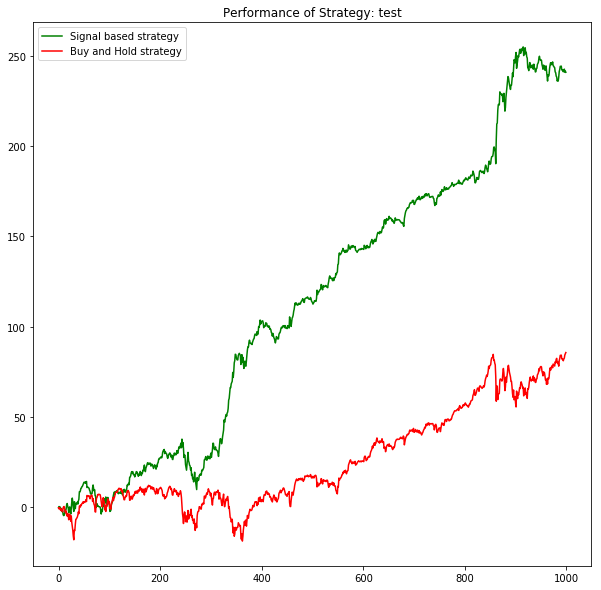

In [10]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy: test')
plt.plot(test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(test['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

#### We can see that for both `train` and `test` our Signal-based strategy outperforms the simple Buy-and-hold strategy.

# Evaluation of model - Practical Standard

We introduce two common practical standards - **Sharpe Ratio**, **Maximum Drawdown** to evaluate our model performance


In [11]:
train['Wealth'] = train['Wealth'] + train.loc[train.index[0], 'Price']
test['Wealth'] = test['Wealth'] + test.loc[test.index[0], 'Price']

In [12]:
# Sharpe Ratio on Train data
train['Return'] = np.log(train['Wealth']) - np.log(train['Wealth'].shift(1))
dailyr = train['Return'].dropna()
daily_sr = dailyr.mean() / dailyr.std(ddof=1)
yearly_sr = (252 ** 0.5) * daily_sr
print('Daily Sharpe Ratio for Train:', daily_sr)
print('Yearly Sharpe Ratio for Train:', yearly_sr)

Daily Sharpe Ratio for Train: 0.179650763033
Yearly Sharpe Ratio for Train: 2.85186745096


In [13]:
# Sharpe Ratio in Test data
test['Return'] = np.log(test['Wealth']) - np.log(test['Wealth'].shift(1))
dailyr = test['Return'].dropna()
daily_sr = dailyr.mean() / dailyr.std(ddof=1)
yearly_sr = (252 ** 0.5) * daily_sr
print('Daily Sharpe Ratio for Test:', daily_sr)
print('Yearly Sharpe Ratio for Test:', yearly_sr)

Daily Sharpe Ratio for Test: 0.130351262086
Yearly Sharpe Ratio for Test: 2.06926213537


In [14]:
# Maximum Drawdown in Train data
train['Peak'] = train['Wealth'].cummax()
train['Drawdown'] = (train['Peak'] - train['Wealth']) / train['Peak']
print(f"Maximum Drawdown for Train: {train['Drawdown'].max():.2%}")

Maximum Drawdown for Train: 6.07%


In [15]:
# Maximum Drawdown in Test data
test['Peak'] = test['Wealth'].cummax()
test['Drawdown'] = (test['Peak'] - test['Wealth']) / test['Peak']
print(f"Maximum Drawdown for Test: {test['Drawdown'].max():.2%}")

Maximum Drawdown for Test: 11.72%


#### We can see that Sharpe Ratio for `train` is higher than that for `test`, both daily and yearly. Maximum Drawdown is higher for the `test`.